In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['HF_HOME'] = 'hf_cache' # Don't want model files in our home directory due to disk quota
os.environ['OPENBLAS_NUM_THREADS'] = '1' # https://stackoverflow.com/questions/75619847/python-sklearn-openblas-error-for-kmeans

from utils import set_seed
import torch

set_seed(1234)

torch.cuda.is_available()

True

In [2]:
from transformers import LukeTokenizer
import const
from model import DocRedModel
import json
from utils import get_holdouts, remove_holdouts, read_docred, collate_fn
from train import train_official, train_contr_candidates, train_contr_cluster
from torch.utils.data import DataLoader

HOLDOUT_BATCH = 0
MODEL_NAME = const.LUKE_BASE

CAND_TMP = 0.01
CAND_SUP_WT = 0.5
CAND_EMBED_SIZE = 768
CAND_NORMALIZE = True

CLUST_TMP = 0.01
CLUST_SUP_WT = 0.5
CLUST_EMBED_SIZE = 768
CLUST_NORMALIZE = True

TRAIN_BATCH_SIZE = 4 # Should we reduce contrastive batch size to 3? This is what we ran originally 
DEV_BATCH_SIZE = 8

cand_dir = f'out/holdout-batch-{HOLDOUT_BATCH}/contr-cand_luke-base_tmp-{CAND_TMP}_supw-{CAND_SUP_WT}_embed-{CAND_EMBED_SIZE}_norm-{CAND_NORMALIZE}'
checkpoint_dir = os.path.join(cand_dir, f'contr-clust_luke-base_tmp-{CLUST_TMP}_supw-{CLUST_SUP_WT}_embed-{CLUST_EMBED_SIZE}_norm-{CLUST_NORMALIZE}', 'checkpoints')

checkpoint_path = os.path.join(checkpoint_dir, 'latest-checkpoint.pt')
print(checkpoint_path)

out/holdout-batch-0/contr-cand_luke-base_tmp-0.01_supw-0.5_embed-768_norm-True/contr-clust_luke-base_tmp-0.01_supw-0.5_embed-768_norm-True/checkpoints/latest-checkpoint.pt


In [3]:
rel2id_original = json.load(open('data/meta/rel2id.json'))
id2rel_original = {v: k for k, v in rel2id_original.items()}
tokenizer = LukeTokenizer.from_pretrained(MODEL_NAME, add_prefix_space=True)

holdout_rel_batches = get_holdouts(train_samples_fp=const.TRAIN_SAMPLES_FP, # Get rel batches
                                   dev_samples_fp=const.DEV_SAMPLES_FP,
                                   rel2id=rel2id_original,
                                   id2rel=id2rel_original,
                                   tokenizer=tokenizer)
holdout_rels = holdout_rel_batches[HOLDOUT_BATCH]

train_samples = read_docred(fp=const.TRAIN_SAMPLES_FP, rel2id=rel2id_original, tokenizer=tokenizer)
dev_samples = read_docred(fp=const.DEV_SAMPLES_FP, rel2id=rel2id_original, tokenizer=tokenizer)  

train_samples, dev_samples, rel2id_holdout, id2rel_holdout = remove_holdouts(train_samples=train_samples,
                                                                             dev_samples=dev_samples,
                                                                             holdout_rels=holdout_rels,
                                                                             rel2id=rel2id_original,
                                                                             id2rel=id2rel_original)

train_dataloader = DataLoader(train_samples, batch_size=TRAIN_BATCH_SIZE, shuffle=True, collate_fn=collate_fn, drop_last=True)
val_train_dataloader = DataLoader(train_samples, batch_size=DEV_BATCH_SIZE, shuffle=False, collate_fn=collate_fn, drop_last=False)
dev_dataloader = DataLoader(dev_samples, batch_size=DEV_BATCH_SIZE, shuffle=False, collate_fn=collate_fn, drop_last=False)

/data2/nhanse02/thesis/venv/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Holdout info file already exists. Loading from file...


data/dev.json: 100%|██████████| 998/998 [00:06<00:00, 154.09it/s]


In [4]:
model = DocRedModel(model_name=MODEL_NAME,
                    tokenizer=tokenizer,
                    num_class=len(rel2id_holdout),
                    mode=const.MODE_CONTRASTIVE_CLUSTER,
                    contr_tmp=CLUST_TMP,
                    contr_clust_sup_wt=CLUST_SUP_WT,
                    out_embed_size=CLUST_EMBED_SIZE).to(const.DEVICE)
model.load_state_dict(torch.load(checkpoint_path, weights_only=True))

<All keys matched successfully>

In [5]:
from train import add_train_mask, validate_epoch
import torch.nn.functional as F

add_train_mask(train_samples, torch.load(os.path.join(cand_dir, 'checkpoints', 'latest-contr-cand-mask.pt')))

embeddings, _, labels, labels_original, train_mask = validate_epoch(model, val_train_dataloader)
if CLUST_NORMALIZE:
    print('NORMALIZING...')
    embeddings = F.normalize(embeddings, dim=-1)
embeddings.shape

/tmp/ipykernel_9469/2963517321.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  add_train_mask(train_samples, torch.load(os.path.join(cand_dir, 'checkpoints', 'latest-con

NORMALIZING...


torch.Size([1198650, 768])

In [6]:
(~train_mask).sum().item()

61313

Dimension Reducing (umap)...
Clustering...
Dimension Reducing (umap)...
-=-=-=PLOT INFO=-=-=-
NUM. POS: 0
NUM. HOLDOUT: 2342
NUM. NEG: 58971
-=-=-=-
LABEL: P69 272/286 (0.95) clustered
261/272 in cluster 34 (size: 884, purity: 0.30)
-----
LABEL: P54 268/272 (0.99) clustered
253/268 in cluster 15 (size: 382, purity: 0.66)
-----
LABEL: P571 260/262 (0.99) clustered
182/260 in cluster 59 (size: 2609, purity: 0.07)
-----
LABEL: P570 618/625 (0.99) clustered
602/618 in cluster 18 (size: 2134, purity: 0.28)
-----
LABEL: P569 893/897 (1.00) clustered
889/893 in cluster 19 (size: 2092, purity: 0.42)
-----


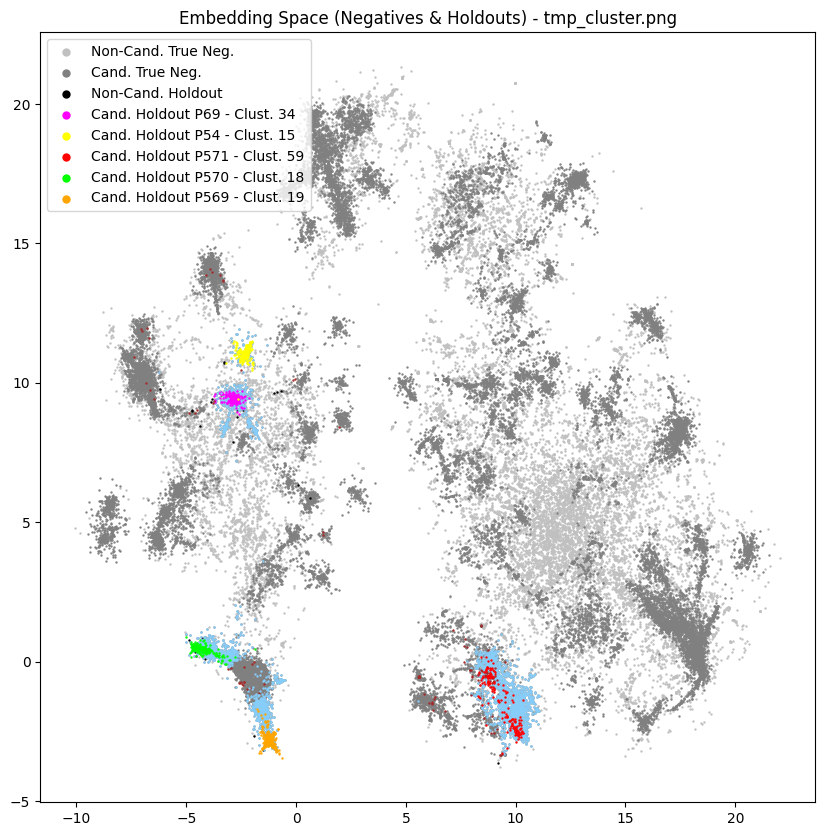

{'cand_cts': {'cand_holdout_ct': 2342,
              'cand_neg_ct': 58971,
              'cand_pos_ct': 0,
              'cand_sample_ct': 61313},
 'clustered_count': 42794,
 'holdout_ari': 0.9612505424781077,
 'holdout_completeness': 0.8723200671188424,
 'holdout_homogeneity': 0.9840938639900173,
 'holdout_macro_completeness': 0.898334468469258,
 'holdout_macro_purity': 0.3468725209358493,
 'holdout_micro_completeness': 0.9338172502134927,
 'holdout_micro_purity': 0.26996667078138503,
 'holdout_noise_ratio': 0.013236549957301452,
 'holdout_v_measure': 0.9248420420700602,
 'num_clusters': 87,
 'original_cts': {'holdout_ct': 2988,
                  'neg_ct': 1163035,
                  'pos_ct': 32627,
                  'sample_ct': 1198650},
 'per_class_stats': {'P54': {'cand_count': 272,
                             'clustered_count': 268,
                             'count': 379,
                             'max_clust': 15,
                             'max_clust_completeness': 0.93

In [7]:
from eval_cluster import cluster_evaluate
from pprint import pprint

stats, pseudolabels, id2rel_holdout_update = cluster_evaluate(embeddings, train_mask, labels, labels_original, id2rel_original, id2rel_holdout, 'tmp_cluster.png')
pprint(stats)

In [ ]:
torch.save(pseudolabels, os.path.join(checkpoint_dir, 'latest-pseudolabels.pt'))
json.dump(id2rel_holdout_update, open(os.path.join(checkpoint_dir, 'latest-id2rel-holdout-update.json'), 'w'), indent=2)
json.dump(stats, open(os.path.join(checkpoint_dir, 'test_stats.json'), 'w'), indent=2)

: 